In [12]:
import numpy as np                                           #For array operations
import matplotlib.pyplot as plt                              #For plotting
from scipy.integrate import solve_ivp                        #For solving ODEs
import os                                                   #For file operations
import scipy.odr as odr                                    #For orthogonal distance regression  

No AUger recombination or detrappping term as ODE was struggling with this. Still is, and will add this back in in the next film

In [13]:
def ABT_rate_equations(t, y, p_cons, k_A, k_T, k_DP, k_DT, k_B, N_T, p_0,bkr):
        """ Rate equation of the BTD model
        
        :param n_e: CB electron concentration (cm-3)
        :param n_h: VB hole concentration (cm-3)
        :param n_t: trapped electron concentration (cm-3)
        :p_cons: proportionality constant for the PL signal
        :param k_A: Auger recombination rate (cm3ns-1)
        :param k_T: trapping rate (cm3ns-1)
        :param k_B: bimolecular recombination rate (cm3ns-1)
        :param k_DT: detrapping rate (cm3ns-1)
        :param k_DP: depopulation rate (cm3ns-1)
        :param N_T: Trapped electron concentration (cm-3)
        :param p_0: hole concentration (cm-3)
        :param bkr: background rate (cm3ns-1)""" 
        
        n_e, n_t, n_h = y
        
        A = k_A * (n_e * (n_h + p_0)**2 + (n_h + p_0) * n_e**2)
        B = k_B * n_e * (n_h + p_0)
        T = k_T * n_e * (N_T - n_t)
        DT = k_DT * n_t 
        DP = k_DP * n_t * (n_h + p_0)
        
        dne_dt = - A - B - T + DT
        dnt_dt = T - DP - DT
        dnh_dt = -A - B - DP
        
        return [dne_dt, dnt_dt, dnh_dt]
    
def calculate_TRPL_ABT(r, t):
    #Solve the ordinary differential equations for the free electron, trapped electron and hole concentrations    
    n = solve_ivp(ABT_rate_equations, (t[0], t[-1]), [r[0], 0, r[0]+r[8]], args=(abs(r[1]), abs(r[2]), abs(r[3]), abs(r[4]), abs(r[5]),abs(r[6]),abs(r[7]),abs(r[8]),abs(r[9])), method = 'DOP853', t_eval = t)['y']
    # Calculate TRPL signal - n*p as PL proprtional to n^2
    sig = r[1] * abs(n[0]) * abs(n[2]) + r[9]
    
    return np.log10(sig)

Simualte TRPL Signal ABT model

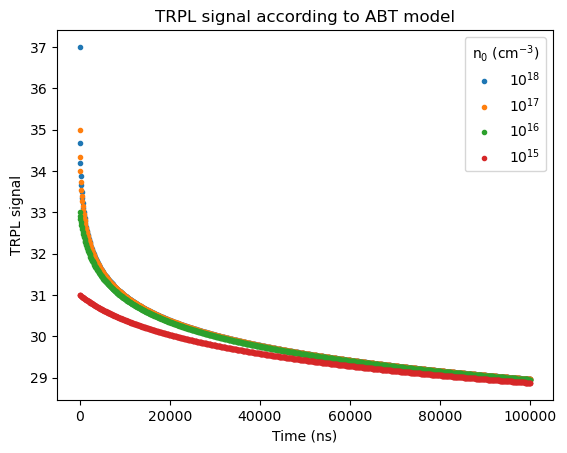

In [14]:
ns = [18,17,16,15]
t= np.linspace(0, 100000, 1000)
p_cons = 1
k_A = -37
k_T = -19
k_DP = -20
k_DT = -1
k_B = -19
N_T = 15
p_0 = 13
bkr = 1

sigs = []
for n in ns:
    sig = calculate_TRPL_ABT([10**n, 10**p_cons, 10**k_A, 10**k_T, 10**k_DP,10**k_DT, 10**k_B, 10**N_T, 10**p_0, bkr], t)
    plt.plot(t,sig,'.',label=f'10$^{{{n}}}$')
    #plt.yscale('log')
    #plt.xscale('log')
    plt.legend(title = f'n$_0$ (cm$^{{-3}}$)')
    plt.title('TRPL signal according to ABT model')
    plt.xlabel('Time (ns)')
    plt.ylabel('TRPL signal')
    sigs.append(sig)



## Make sure I can fit ODR to simulated data inputting same parameters

Beta: [1.e+18 1.e+01 1.e-37 1.e-19 1.e-20 1.e-01 1.e-19 1.e+15 1.e+13 1.e+00]
Beta Std Error: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Beta Covariance: [[ 7.30572270e+41 -1.46113918e+25 -1.46107155e-13 -2.37914284e+04
   6.16961959e+03 -5.92348169e+19 -7.30827438e+04 -1.63000064e+37
   7.32812637e+36  0.00000000e+00]
 [-1.46113918e+25  2.92227296e+08  2.92213796e-30  4.75822872e-13
  -1.23392196e-13  1.18468849e+03  1.46165217e-12  3.26064740e+20
  -1.46562251e+20  0.00000000e+00]
 [-1.46107155e-13  2.92213796e-30  2.92201598e-68  4.75256466e-51
  -1.23424150e-51  1.18404677e-35  1.46158476e-50  3.38228075e-18
  -1.46554876e-18  0.00000000e+00]
 [-2.37914284e+04  4.75822872e-13  4.75256466e-51  1.43015455e-32
  -2.02969789e-34 -1.41086471e-17  2.38213268e-33 -8.15560288e+01
  -2.38676755e-01  0.00000000e+00]
 [ 6.16961959e+03 -1.23392196e-13 -1.23424150e-51 -2.02969789e-34
   1.07378859e-34  9.31635507e-19 -6.17534312e-34 -7.92447556e+00
   6.17189572e-02  0.00000000e+00]
 [-5.92348169e+19  1.1

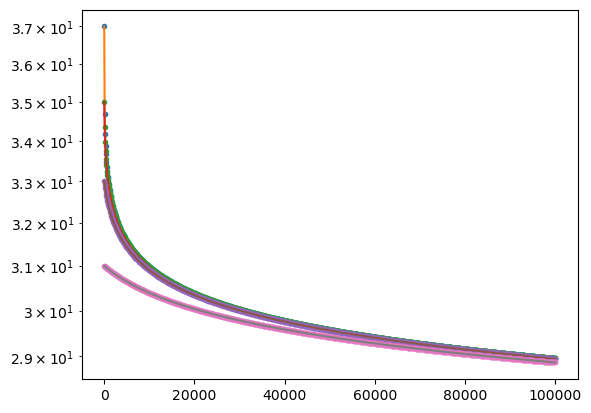

In [15]:
for sig,n in zip(sigs,ns):

    mod = odr.Model(calculate_TRPL_ABT)
    mydata = odr.Data(t, sig)
    #r = [n0, y, k_T, k_DP, k_B, N_T, p_0]
    myodr = odr.ODR(mydata, mod, beta0 = [10**n, 10**p_cons, 10**k_A, 10**k_T, 10**k_DP,10**k_DT, 10**k_B, 10**N_T, 10**p_0, bkr], ifixb = [1, 1, 1, 1, 1,1,1,1,1,1])

    run = myodr.run()

    print(run.pprint())
    

    plt.plot(t, sig, '.', label = f'{n} Simulated')
    plt.plot(t, (calculate_TRPL_ABT(abs(run.beta), t)), label = f'{n} Fit')
    plt.yscale('log')
    

Try to fit to real data by hand

In [16]:
film_files = [f for f in os.listdir('MAPI_230424_Sorted/') if f.endswith('.npy')and 'FILM' in f]
c60_files = [f for f in os.listdir('MAPI_230424_Sorted/') if f.endswith('.npy')and 'C60' in f]
fluences = [7.1e17, 7.1e+16, 7.1e+15]
print(film_files)
print(c60_files)
print(fluences)

['iCCD_MAPI_2706_150uW_FILM.npy', 'iCCD_MAPI_2706_15uW_FILM.npy', 'iCCD_MAPI_2706_1p5uW_FILM.npy']
['iCCD_MAPI_2706_150uW_C60.npy', 'iCCD_MAPI_2706_15uW_C60.npy', 'iCCD_MAPI_2706_1p5uW_C60.npy']
[7.1e+17, 7.1e+16, 7100000000000000.0]


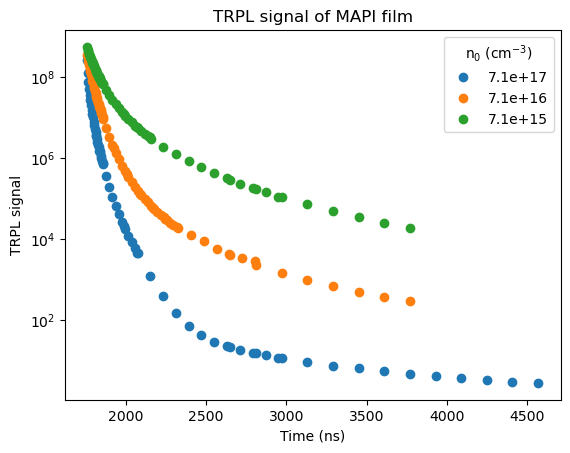

[5.291424296848226e-28, 6.941726063833711e-26, 1.1024759804737427e-23]


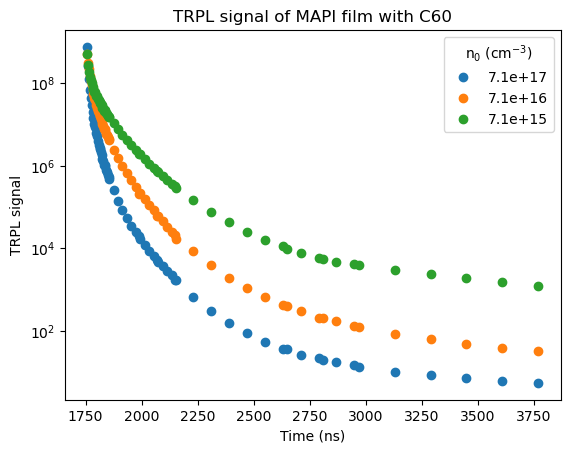

[1.4733513421200377e-27, 1.0155186937857682e-25, 9.781960527723273e-24]


In [17]:
film_datas = []
    
for file,fluence in zip(film_files,fluences):
    data = np.load('MAPI_230424_Sorted/'+file)
    film_datas.append(data)
    plt.plot(data[0], data[1], 'o', label=f'{fluence:.1e}')
    plt.yscale('log')
    plt.legend(title = f'n$_0$ (cm$^{{-3}}$)')
    plt.title('TRPL signal of MAPI film')
    plt.xlabel('Time (ns)')
    plt.ylabel('TRPL signal')
plt.show()

film_Cs = [pl[1][0]/fluence**2 for pl,fluence in zip(film_datas,fluences)] # Caclculate conversion factors for each data set
print(film_Cs)

c60_datas = []
    
for file,fluence in zip(c60_files,fluences):
    data = np.load('MAPI_230424_Sorted/'+file)
    c60_datas.append(data)
    plt.plot(data[0], data[1], 'o', label=f'{fluence:.1e}')
    plt.yscale('log')
    plt.legend(title = f'n$_0$ (cm$^{{-3}}$)')
    plt.title('TRPL signal of MAPI film with C60')
    plt.xlabel('Time (ns)')
    plt.ylabel('TRPL signal')
plt.show()
c60_Cs = [pl[1][0]/fluence**2 for pl,fluence in zip(c60_datas,fluences)]
print(c60_Cs)

## Try to fit by hand

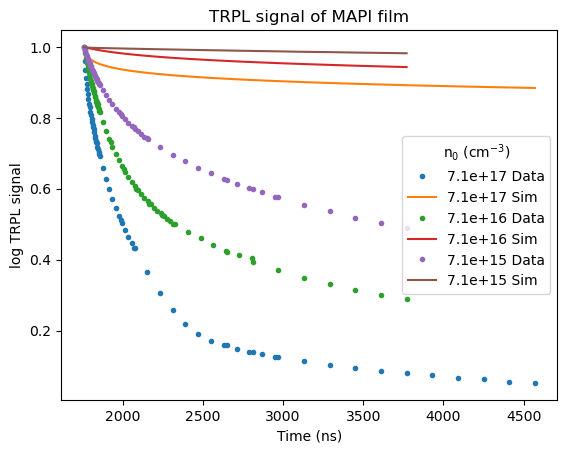

In [18]:
film_datas = []

k_A = -37
k_T = -17
k_DP = -19.5
k_DT = -18
k_B = -19.3
N_T = 15
p_0 = 13
bkr = 1

    
    
for file,fluence in zip(film_files,fluences):
    
    data = np.load('MAPI_230424_Sorted/'+file)
    film_datas.append(data)
    time = data[0]
    
    signal = np.log10(data[1])
    p_cons = signal[0]/fluence**2 #conversion factor shouldnt actually matter if this is all normalised
    
    sim_sig = calculate_TRPL_ABT([fluence, 10**p_cons, 10**k_A, 10**k_T, 10**k_DP,10**k_DT, 10**k_B, 10**N_T, 10**p_0, bkr], data[0]) #calculated simulated signal
    
    plt.plot(data[0], np.log10(data[1])/np.log10(data[1][0]), '.', label=f'{fluence:.1e} Data') # normalised data
    plt.plot(data[0],sim_sig/sim_sig[0], label=f'{fluence:.1e} Sim')                            # normalised simulated signal
    
    #plt.yscale('log')
    plt.legend(title = f'n$_0$ (cm$^{{-3}}$)')
    plt.title('TRPL signal of MAPI film')
    plt.xlabel('Time (ns)')
    plt.ylabel('log TRPL signal')
plt.show()

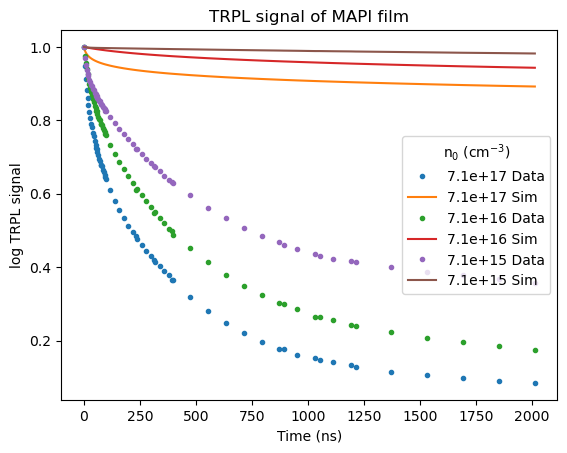

In [19]:
c60_datas = []
    
k_A = -37
k_T = -17
k_DP = -19.5
k_DT = -18
k_B = -19.3
N_T = 15
p_0 = 13
bkr = 1

    
    
for file,fluence in zip(c60_files,fluences):
    
    data = np.load('MAPI_230424_Sorted/'+file)
    c60_datas.append(data)
    time = data[0] - data[0][0]
    signal = np.log10(data[1])
    p_cons = signal[0]/fluence**2 #conversion factor shouldnt actually matter if this is all normalised
    
    sim_sig = calculate_TRPL_ABT([fluence, 10**p_cons, 10**k_A, 10**k_T, 10**k_DP,10**k_DT, 10**k_B, 10**N_T, 10**p_0, bkr], time) #calculated simulated signal
    
    plt.plot(time, signal/signal[0], '.', label=f'{fluence:.1e} Data') # normalised data
    plt.plot(time,sim_sig/sim_sig[0], label=f'{fluence:.1e} Sim')                            # normalised simulated signal
    
    #plt.yscale('log')
    plt.legend(title = f'n$_0$ (cm$^{{-3}}$)')
    plt.title('TRPL signal of MAPI film')
    plt.xlabel('Time (ns)')
    plt.ylabel('log TRPL signal')

In [20]:
for data,n,C in zip(film_datas, ns, film_Cs):
    time = data[0]-data[0][0] #time in ns
    signal = data[1] 

    mod = odr.Model(calculate_TRPL_ABT)
    mydata = odr.Data(time, np.log10(signal))
    #r = [n0, y, k_T, k_DP, k_B, N_T, p_0]
    myodr = odr.ODR(mydata, mod, beta0 = [10**n, 10**C, 10**k_A, 10**k_T, 10**k_DP,10**k_DT, 10**k_B, 10**N_T, 10**p_0, bkr], ifixb = [1, 1, 1, 1, 1,1,1,1,1,1])

    run = myodr.run()

    print(run.pprint())
    

    plt.plot(time, 10**signal, 'o')
    plt.plot(time, 10**(calculate_TRPL_ABT(abs(run.beta), time)), label = f'{fluence:.0e}')
    plt.yscale('log')
    plt.show()


: 

C:\Users\bail2.BLUE\AppData\Local\Temp\ipykernel_25908\2144949582.py:37: RuntimeWarning: invalid value encountered in log10
  return np.log10(sig)


Beta: [1.00000000e+18 2.37397585e-10 1.22092491e-37 9.99559252e-20
 1.00005473e-20 1.00032978e-01 2.04247155e-19 9.99529182e+14
 1.00036838e+13 1.00000000e+00]
Beta Std Error: [0.00000000e+00 1.07526372e-08 1.58531973e-35 2.27408367e-15
 7.11312670e-16 1.02033438e+03 1.16727302e-17 8.62326005e+19
 1.19954560e+17 0.00000000e+00]
Beta Covariance: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.89472215e-19  1.79948136e-46 -3.88576794e-27
  -1.44805135e-27  5.90831005e-10  1.34546665e-28  1.53313205e+08
   2.80321163e+04  0.00000000e+00]
 [ 0.00000000e+00  1.79948136e-46  6.29231752e-73  4.05418899e-53
   9.38169923e-54  1.55591848e-35 -2.74990275e-55 -2.59585609e-18
   3.60137310e-21  0.00000000e+00]
 [ 0.00000000e+00 -3.88576794e-27  4.05418899e-53  1.29476150e-32
   3.85408582e-33 -1.72507398e-15 -3.87730545e-35 -3.51615441e+02
   4.20182641e-01  0

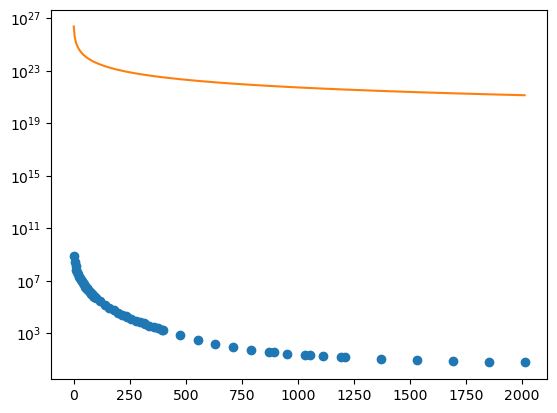

Beta: [1.00000000e+17 7.22917017e-11 1.07217424e-37 9.99294480e-20
 1.00020846e-20 1.00078692e-01 1.88092149e-19 1.00011901e+15
 1.00099808e+13 1.00000000e+00]
Beta Std Error: [0.00000000e+00 2.39344487e-09 7.06909572e-35 4.37504115e-15
 4.31804209e-16 4.87550223e+02 1.04888266e-17 9.04683863e+19
 1.65110542e+17 0.00000000e+00]
Beta Covariance: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.71327101e-20 -7.78055278e-47 -2.19914783e-26
   1.24718992e-27 -4.44284585e-10  4.98392798e-29  4.48586530e+08
  -2.40600767e+05  0.00000000e+00]
 [ 0.00000000e+00 -7.78055278e-47  1.49453790e-71  6.19694380e-52
  -4.98561945e-53  1.98179980e-35 -1.84381275e-54 -1.33912130e-17
   3.00373234e-20  0.00000000e+00]
 [ 0.00000000e+00 -2.19914783e-26  6.19694380e-52  5.72457820e-32
  -3.40048735e-33  7.52141830e-16 -1.23189951e-34 -1.18218001e+03
   1.08788883e+00  0

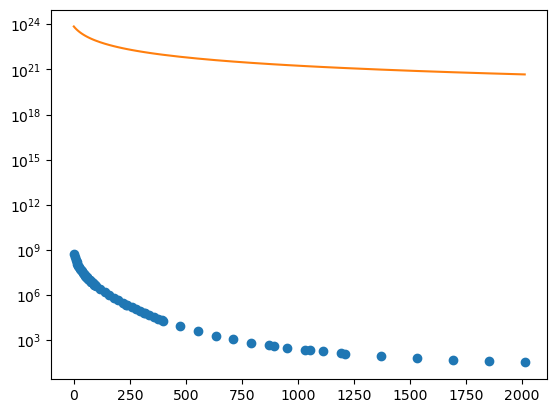

Beta: [1.00000000e+16 2.19056217e-10 1.00539124e-37 1.00025983e-19
 1.00002083e-20 9.99802893e-02 1.36620562e-19 1.00040940e+15
 9.99867024e+12 1.00000000e+00]
Beta Std Error: [0.00000000e+00 2.28652973e-08 2.30685948e-33 5.43191243e-15
 1.17452554e-15 7.06230827e+02 5.89052088e-17 7.55803284e+19
 9.73921087e+17 0.00000000e+00]
Beta Covariance: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.80913620e-18 -1.70710549e-43 -2.72670562e-25
   3.68296631e-26  1.28642272e-08  4.52653158e-27  4.38634327e+09
  -7.38548450e+07  0.00000000e+00]
 [ 0.00000000e+00 -1.70710549e-43  1.84144961e-68  2.45205986e-50
  -4.60325350e-51 -7.73685940e-34 -4.65154559e-52 -3.60547521e-16
   7.52042541e-18  0.00000000e+00]
 [ 0.00000000e+00 -2.72670562e-25  2.45205986e-50  1.02099374e-31
   8.76094129e-33 -1.04454311e-14 -6.91447158e-34 -1.27174351e+03
   1.16367875e+01  0

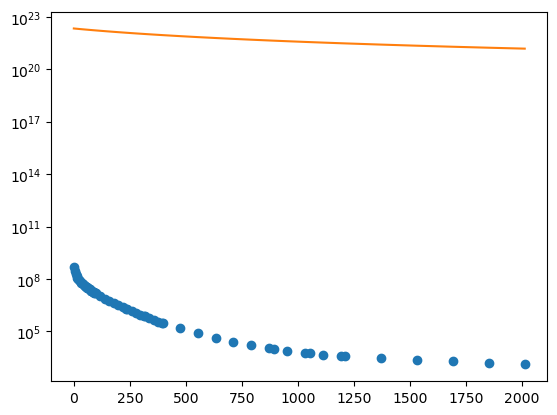

In [ ]:
for data,n,C in zip(c60_datas, ns, c60_Cs):
    time = data[0]-data[0][0] #time in ns
    signal = data[1]/data[1][0] 

    mod = odr.Model(calculate_TRPL_ABT)
    mydata = odr.Data(time, np.log10(signal))
    #r = [n0, y, k_T, k_DP, k_B, N_T, p_0]
    myodr = odr.ODR(mydata, mod, beta0 = [10**n, 10**C, 10**k_A, 10**k_T, 10**k_DP,10**k_DT, 10**k_B, 10**N_T, 10**p_0, bkr], ifixb = [1, 1, 1, 1, 1,1,1,1,1,1])

    run = myodr.run()

    print(run.pprint())
    
    sim_signal = 10**(calculate_TRPL_ABT(abs(run.beta), time))

    plt.plot(time, signal, '.', label = f'{fluence:.0e} Data')
    plt.plot(time, sim_signal, label = f'{fluence:.0e} Sim')
    plt.yscale('log')
    plt.show()